In [1]:
import os
import shutil
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.metrics import Recall,Precision
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras import models, layers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
root_path = Path("../input/a-large-scale-fish-dataset/Fish_Dataset")
sub_paths = root_path.glob(r'**/*.png')
#converting to list, will deal with generator later
sub_paths = list(sub_paths)

#creating temporary list to handle generator
data = []
for i in range(len(sub_paths)):
    #get the 2nd from last directory name
    label = os.path.split(os.path.split(sub_paths[i])[0])[1]
    data.append([str(sub_paths[i]), label])
    
#Appending data to dataframe
df = pd.DataFrame(data, columns=['path', 'label'])
#Removing ground truths 
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)

In [3]:
#Splitting into training, validation, and testing data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2, shuffle=True)
train_df.count()
test_df.count()

path     7200
label    7200
dtype: int64

path     1800
label    1800
dtype: int64

# ImageDataGenerator

In [4]:
#Importing images using image data preprocessing provided from keras
train_generator = ImageDataGenerator(validation_split=0.2)
test_generator = ImageDataGenerator()

train_imgs = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "path",
    y_col = "label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "training"
)

val_imgs = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "path",
    y_col = "label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "validation"
)

test_imgs = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = "path",
    y_col = "label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = False
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


# Model Initialization

In [5]:
# Model Initialization

base_model = VGG19(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

80142336/80134624 [==============================] - 1s 0us/step


# Freezing Layers

In [6]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

# Building Model

In [7]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(9,activation='softmax'))

In [8]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0

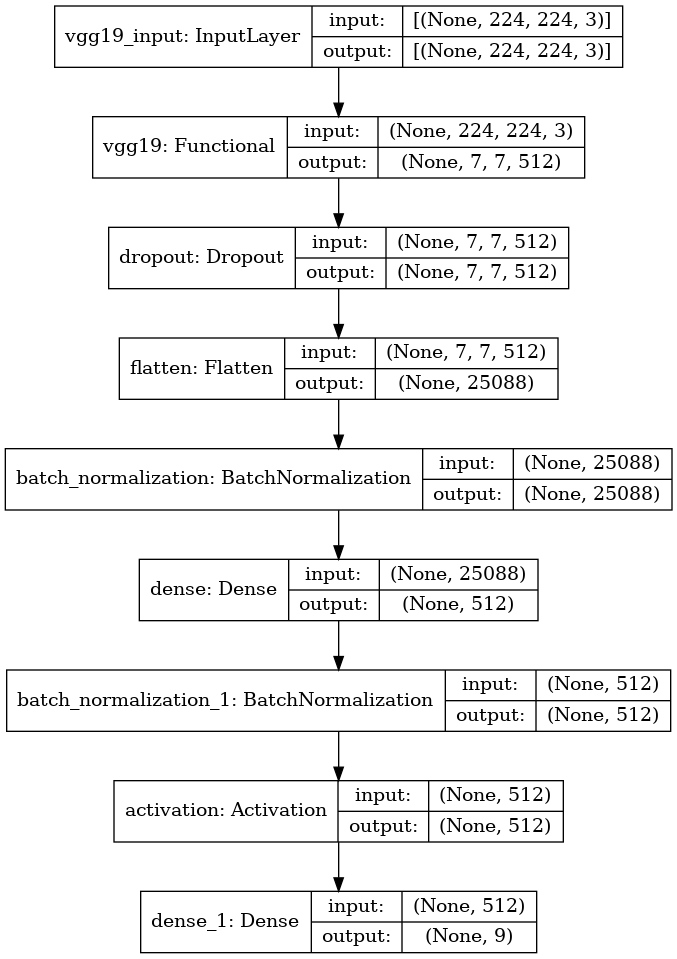

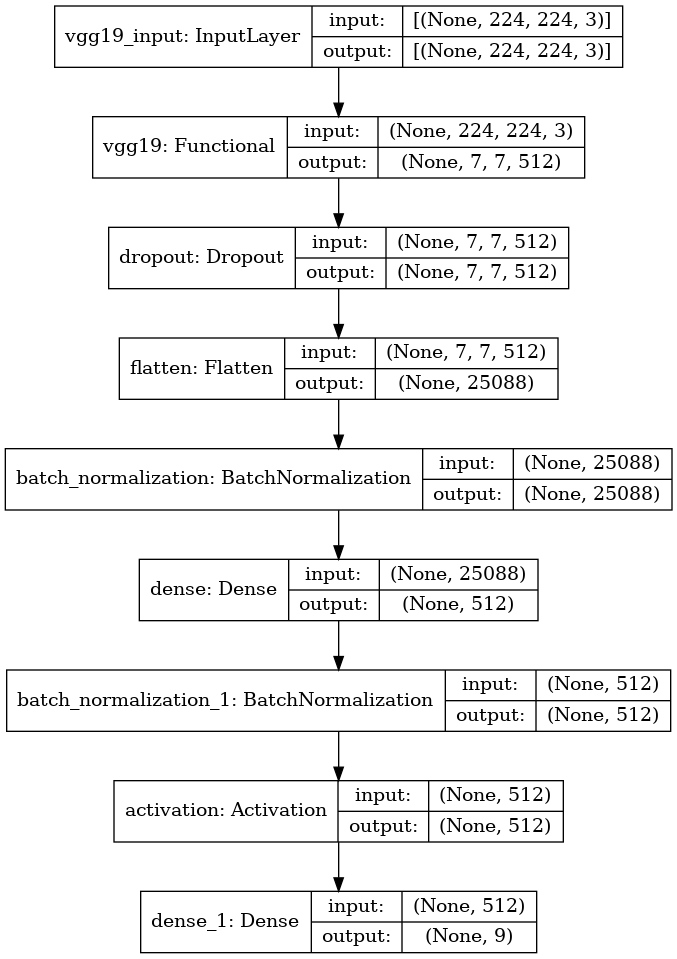

In [9]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

# Model Compile 

In [10]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy',Precision(),Recall()],
              optimizer=OPT)

# Defining Callbacks

In [11]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [12]:
model_history=model.fit(train_imgs,
                        validation_data=val_imgs,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
180/180 [==============================] - 138s 711ms/step - loss: 0.5811 - accuracy: 0.8117 - precision: 0.8637 - recall: 0.7736 - val_loss: 0.0213 - val_accuracy: 0.9937 - val_precision: 0.9944 - val_recall: 0.9937

Epoch 00001: val_accuracy improved from -inf to 0.99375, saving model to ./best_weights.hdf5
Epoch 2/10
180/180 [==============================] - 72s 402ms/step - loss: 0.0193 - accuracy: 0.9974 - precision: 0.9975 - recall: 0.9968 - val_loss: 0.0117 - val_accuracy: 0.9951 - val_precision: 0.9958 - val_recall: 0.9951

Epoch 00002: val_accuracy improved from 0.99375 to 0.99514, saving model to ./best_weights.hdf5
Epoch 3/10
180/180 [==============================] - 72s 400ms/step - loss: 0.0105 - accuracy: 0.9977 - precision: 0.9978 - recall: 0.9977 - val_loss: 0.0135 - val_accuracy: 0.9972 - val_precision: 0.9972 - val_recall: 0.9972

Epoch 00003: val_accuracy improved from 0.99514 to 0.99722, saving model to ./best_weights.hdf5
Epoch 4/10
180/180 [==========

In [13]:
import keras
model.save('./best_weights.hdf5')
#model = keras.models.load_model('./best_weights.hdf5')

# Plot

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

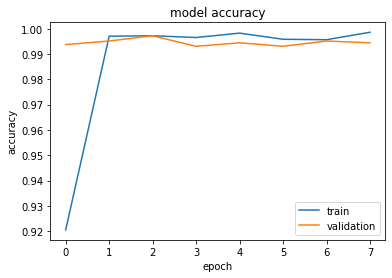

Text(0.5, 1.0, 'train set loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

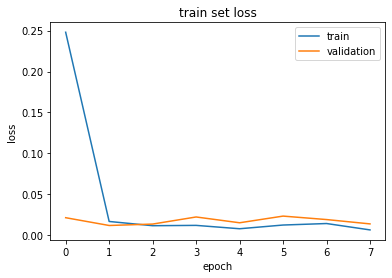

Text(0.5, 1.0, ' precision')

Text(0, 0.5, 'precision')

Text(0.5, 0, 'epoch')

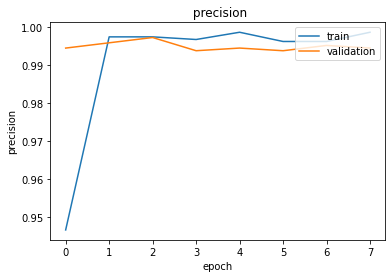

Text(0.5, 1.0, ' recall')

Text(0, 0.5, 'recall')

Text(0.5, 0, 'epoch')

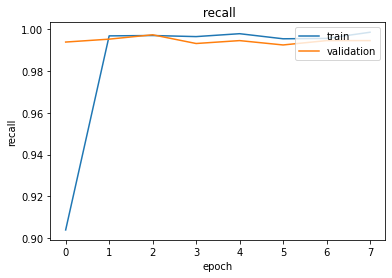

In [14]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(model_history.history['precision'])
plt.plot(model_history.history['val_precision'])
plt.title(' precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


plt.plot(model_history.history['recall'])
plt.plot(model_history.history['val_recall'])
plt.title(' recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


# Test

In [15]:
loss, accuracy , precision,recall=model.evaluate(test_imgs)
print('Test Accuracy: %.3f' % accuracy)
print('Test Precision: %.3f' % precision)
print('Test Recall: %.3f' % recall)
print('Test loss: %.3f' % loss)


57/57 [==============================] - 32s 565ms/step - loss: 0.0155 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956
Test Accuracy: 0.996
Test Precision: 0.996
Test Recall: 0.996
Test loss: 0.015


In [16]:
y_pred = model.predict(test_imgs)
y_pred = np.argmax(y_pred,axis=1)

In [17]:
from sklearn.metrics import classification_report
print(classification_report(test_imgs.labels,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       0.99      0.99      0.99       189
           2       1.00      1.00      1.00       210
           3       1.00      0.99      0.99       202
           4       1.00      1.00      1.00       205
           5       1.00      0.99      1.00       216
           6       0.99      1.00      1.00       192
           7       0.98      0.99      0.99       184
           8       1.00      1.00      1.00       192

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800

